In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import joblib

In [ ]:
df = pd.read_csv("D:\Education\Coding\Machine Learning\Machine Learning Projects\Rain Fall Prediction\weather.csv")
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No
145458,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,...,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


In [3]:
numerical_feature = [feature for feature in df.columns if df[feature].dtypes != 'O']
discrete_feature=[feature for feature in numerical_feature if len(df[feature].unique())<25]
continuous_feature = [feature for feature in numerical_feature if feature not in discrete_feature]
categorical_feature = [feature for feature in df.columns if feature not in numerical_feature]
print("Numerical Features Count {}".format(len(numerical_feature)))
print("Discrete feature Count {}".format(len(discrete_feature)))
print("Continuous feature Count {}".format(len(continuous_feature)))
print("Categorical feature Count {}".format(len(categorical_feature)))

Numerical Features Count 16
Discrete feature Count 2
Continuous feature Count 14
Categorical feature Count 7


In [4]:
print(f"Initial DataFrame shape: {df.shape}")

Initial DataFrame shape: (145460, 23)


In [5]:
# Handle missing values in RainToday and RainTomorrow while still categorical
def fill_categorical_nan(df, variable):
    if not df[variable].dropna().empty:
        mode = df[variable].mode()[0]
        df[variable] = df[variable].fillna(mode)
    else:
        df[variable] = df[variable].fillna('No')

fill_categorical_nan(df, "RainToday")
fill_categorical_nan(df, "RainTomorrow")

print(f"Shape after handling RainToday/RainTomorrow NaNs: {df.shape}")

Shape after handling RainToday/RainTomorrow NaNs: (145460, 23)


In [6]:
# Convert RainToday and RainTomorrow to numerical
df["RainToday"] = df["RainToday"].map({"Yes": 1, "No": 0})
df["RainTomorrow"] = df["RainTomorrow"].map({"Yes": 1, "No": 0})

print(f"Shape after converting RainToday/RainTomorrow to numeric: {df.shape}")

Shape after converting RainToday/RainTomorrow to numeric: (145460, 23)


In [7]:
# Handle missing values in numerical features using randomsampleimputation and median
def randomsampleimputation(df, variable):
    if df[variable].isnull().sum() > 0:
        random_sample = df[variable].dropna().sample(df[variable].isnull().sum(), random_state=0)
        random_sample.index = df[df[variable].isnull()].index
        df.loc[df[variable].isnull(), variable] = random_sample
randomsampleimputation(df, "Cloud9am")
randomsampleimputation(df, "Cloud3pm")
randomsampleimputation(df, "Evaporation")
randomsampleimputation(df, "Sunshine")

for feature in continuous_feature:
    if feature not in ["Cloud9am", "Cloud3pm", "Evaporation", "Sunshine"]:
        df[feature] = df[feature].fillna(df[feature].median())

print(f"Shape after handling numerical NaNs: {df.shape}")

Shape after handling numerical NaNs: (145460, 23)


In [8]:
# Handle missing values in categorical features (excluding RainToday and RainTomorrow which are now numeric)
def mode_nan(df,variable):
    if not df[variable].dropna().empty:
        mode=df[variable].value_counts().index[0]
        df[variable] = df[variable].fillna(mode)
    else:
        df[variable] = df[variable].fillna(0)

In [9]:
# Define mapping dictionaries
windgustdir = {'NNW':0, 'NW':1, 'WNW':2, 'N':3, 'W':4, 'WSW':5, 'NNE':6, 'S':7, 'SSW':8, 'SW':9, 'SSE':10,
       'NE':11, 'SE':12, 'ESE':13, 'ENE':14, 'E':15}
winddir9am = {'NNW':0, 'N':1, 'NW':2, 'NNE':3, 'WNW':4, 'W':5, 'WSW':6, 'SW':7, 'SSW':8, 'NE':9, 'S':10,
       'SSE':11, 'ENE':12, 'SE':13, 'ESE':14, 'E':15}
winddir3pm = {'NW':0, 'NNW':1, 'N':2, 'WNW':3, 'W':4, 'NNE':5, 'WSW':6, 'SSW':7, 'S':8, 'SW':9, 'SE':10,
       'NE':11, 'SSE':12, 'ENE':13, 'E':14, 'ESE':15}
location = {'Portland':1, 'Cairns':2, 'Walpole':3, 'Dartmoor':4, 'MountGambier':5,
       'NorfolkIsland':6, 'Albany':7, 'Witchcliffe':8, 'CoffsHarbour':9, 'Sydney':10,
       'Darwin':11, 'MountGinini':12, 'NorahHead':13, 'Ballarat':14, 'GoldCoast':15,
       'SydneyAirport':16, 'Hobart':17, 'Watsonia':18, 'Newcastle':19, 'Wollongong':20,
       'Brisbane':21, 'Williamtown':22, 'Launceston':23, 'Adelaide':24, 'MelbourneAirport':25,
       'Perth':26, 'Sale':27, 'Melbourne':28, 'Canberra':29, 'Albury':30, 'Penrith':31,
       'Nuriootpa':32, 'BadgerysCreek':33, 'Tuggeranong':34, 'PerthAirport':35, 'Bendigo':36,
       'Richmond':37, 'WaggaWagga':38, 'Townsville':39, 'PearceRAAF':40, 'SalmonGums':41,
       'Moree':42, 'Cobar':43, 'Mildura':44, 'Katherine':45, 'AliceSprings':46, 'Nhil':47,
       'Woomera':48, 'Uluru':49}


df["WindGustDir"] = df["WindGustDir"].map(windgustdir)
df["WindDir9am"] = df["WindDir9am"].map(winddir9am)
df["WindDir3pm"] = df["WindDir3pm"].map(winddir3pm)
df["Location"] = df["Location"].map(location)

mode_nan(df, "WindGustDir")
mode_nan(df, "WindDir9am")
mode_nan(df, "WindDir3pm")
mode_nan(df, "Location")

print(f"Shape after handling categorical NaNs and mapping: {df.shape}")

Shape after handling categorical NaNs and mapping: (145460, 23)


In [10]:
# Date related numerical features (extract month and day, then fill NaNs)
if "Date" in df.columns:
    df["Date"] = pd.to_datetime(df["Date"], format = "%Y-%m-%d", errors = "coerce")
    df["Date_month"] = df["Date"].dt.month
    df["Date_day"] = df["Date"].dt.day

    df["Date_month"] = df["Date_month"].fillna(df["Date_month"].median())
    df["Date_day"] = df["Date_day"].fillna(df["Date_day"].median())

    # Drop the original Date column
    df = df.drop("Date", axis=1)

print(f"Shape after processing Date column: {df.shape}")

Shape after processing Date column: (145460, 24)


In [11]:
# Define X and Y
X = df.drop("RainTomorrow", axis=1)
Y = df["RainTomorrow"]

print(f"Shape of X: {X.shape}")
print(f"Shape of Y: {Y.shape}")

Shape of X: (145460, 23)
Shape of Y: (145460,)


In [12]:
display(df.isnull().sum())

Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
Date_month       0
Date_day         0
dtype: int64

In [13]:
display(df.head())

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Date_month,Date_day
0,30,13.4,22.9,0.6,2.4,8.3,4.0,44.0,5.0,3.0,...,1007.7,1007.1,8.0,0.0,16.9,21.8,0,0,12,1
1,30,7.4,25.1,0.0,3.6,10.0,2.0,44.0,0.0,6.0,...,1010.6,1007.8,7.0,1.0,17.2,24.3,0,0,12,2
2,30,12.9,25.7,0.0,2.6,4.4,5.0,46.0,5.0,6.0,...,1007.6,1008.7,8.0,2.0,21.0,23.2,0,0,12,3
3,30,9.2,28.0,0.0,18.4,8.9,11.0,24.0,13.0,14.0,...,1017.6,1012.8,0.0,5.0,18.1,26.5,0,0,12,4
4,30,17.5,32.3,1.0,5.4,3.0,4.0,41.0,12.0,0.0,...,1010.8,1006.0,7.0,8.0,17.8,29.7,0,0,12,5


In [14]:
display(X.head())

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,Date_month,Date_day
0,30,13.4,22.9,0.6,2.4,8.3,4.0,44.0,5.0,3.0,...,22.0,1007.7,1007.1,8.0,0.0,16.9,21.8,0,12,1
1,30,7.4,25.1,0.0,3.6,10.0,2.0,44.0,0.0,6.0,...,25.0,1010.6,1007.8,7.0,1.0,17.2,24.3,0,12,2
2,30,12.9,25.7,0.0,2.6,4.4,5.0,46.0,5.0,6.0,...,30.0,1007.6,1008.7,8.0,2.0,21.0,23.2,0,12,3
3,30,9.2,28.0,0.0,18.4,8.9,11.0,24.0,13.0,14.0,...,16.0,1017.6,1012.8,0.0,5.0,18.1,26.5,0,12,4
4,30,17.5,32.3,1.0,5.4,3.0,4.0,41.0,12.0,0.0,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0,12,5


In [15]:
display(Y.head())

0    0
1    0
2    0
3    0
4    0
Name: RainTomorrow, dtype: int64

In [16]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X) # Scale the features

X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=0) # Removed stratify=Y

In [17]:
sm = SMOTE(random_state=0)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_train_res)))

The number of classes before fit Counter({0: 90857, 1: 25511})
The number of classes after fit Counter({1: 90857, 0: 90857})


In [18]:
logreg = LogisticRegression()
logreg.fit(X_train_res, y_train_res)

LogisticRegression()

In [19]:
y_pred2 = logreg.predict(X_test)
print(confusion_matrix(y_test,y_pred2))

[[18044  4682]
 [ 1560  4806]]


In [20]:
print(accuracy_score(y_test,y_pred2))

0.7854392960263991


In [21]:
print(classification_report(y_test,y_pred2))

              precision    recall  f1-score   support

           0       0.92      0.79      0.85     22726
           1       0.51      0.75      0.61      6366

    accuracy                           0.79     29092
   macro avg       0.71      0.77      0.73     29092
weighted avg       0.83      0.79      0.80     29092



np.float64(0.7744643125085693)

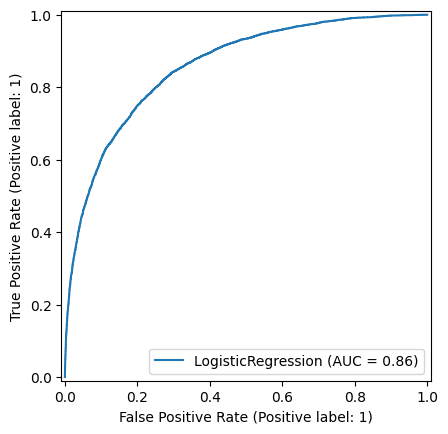

In [22]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(logreg, X_test, y_test)
metrics.roc_auc_score(y_test, y_pred2, average=None)

KNN Model Evaluation: 
 
Confusion_matrix :
[[17418  5308]
 [ 2028  4338]]
Accuracy Score :
0.7478344562078922
Classification Report :
              precision    recall  f1-score   support

           0       0.90      0.77      0.83     22726
           1       0.45      0.68      0.54      6366

    accuracy                           0.75     29092
   macro avg       0.67      0.72      0.68     29092
weighted avg       0.80      0.75      0.76     29092



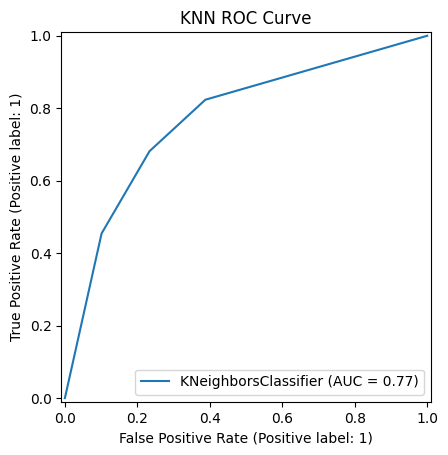

KNN ROC AUC Score: 0.7239337655500604


In [23]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, RocCurveDisplay
import matplotlib.pyplot as plt

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_res, y_train_res)


y_pred4 = knn.predict(X_test)
print("KNN Model Evaluation: \n ")
print("Confusion_matrix :")
print(confusion_matrix(y_test,y_pred4))
print("Accuracy Score :")
print(accuracy_score(y_test,y_pred4))
print("Classification Report :")
print(classification_report(y_test,y_pred4))
RocCurveDisplay.from_estimator(knn, X_test, y_test)
plt.title("KNN ROC Curve")
plt.show()
print("KNN ROC AUC Score:", metrics.roc_auc_score(y_test, y_pred4, average=None))


SVC Model Evaluation: 

Confusion_matrix :
[[18442  4284]
 [ 1514  4852]]
Accuracy Score :
0.8007012237041111
Classification Report :
              precision    recall  f1-score   support

           0       0.92      0.81      0.86     22726
           1       0.53      0.76      0.63      6366

    accuracy                           0.80     29092
   macro avg       0.73      0.79      0.75     29092
weighted avg       0.84      0.80      0.81     29092



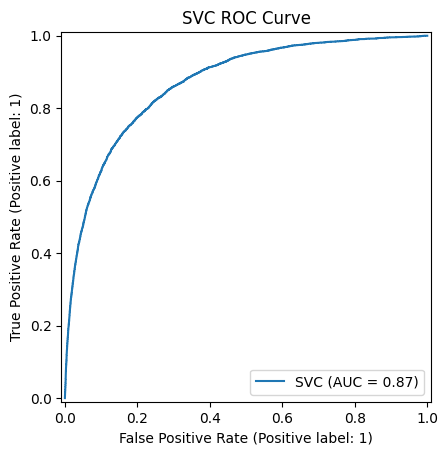

SVC ROC AUC Score: 0.7868337466357745


In [24]:
svc = SVC()
svc.fit(X_train_res, y_train_res)

y_pred5 = svc.predict(X_test)
print("\nSVC Model Evaluation: \n")
print("Confusion_matrix :")
print(confusion_matrix(y_test,y_pred5))
print("Accuracy Score :")
print(accuracy_score(y_test,y_pred5))
print("Classification Report :")
print(classification_report(y_test,y_pred5))
RocCurveDisplay.from_estimator(svc, X_test, y_test)
plt.title("SVC ROC Curve")
plt.show()
print("SVC ROC AUC Score:", metrics.roc_auc_score(y_test, y_pred5, average=None))


Random Forest Model Evaluation: 

Confusion_matrix :
[[20629  2097]
 [ 2422  3944]]
Accuracy Score :
0.8446652000549979
Classification Report :
              precision    recall  f1-score   support

           0       0.89      0.91      0.90     22726
           1       0.65      0.62      0.64      6366

    accuracy                           0.84     29092
   macro avg       0.77      0.76      0.77     29092
weighted avg       0.84      0.84      0.84     29092



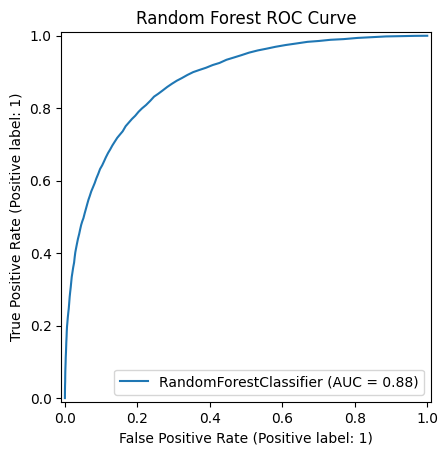

Random Forest ROC AUC Score: 0.7636340729645735


In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, RocCurveDisplay
import matplotlib.pyplot as plt

rf = RandomForestClassifier(random_state=0)
rf.fit(X_train_res, y_train_res)

y_pred_rf = rf.predict(X_test)
print("\nRandom Forest Model Evaluation: \n")
print("Confusion_matrix :")
print(confusion_matrix(y_test,y_pred_rf))
print("Accuracy Score :")
print(accuracy_score(y_test,y_pred_rf))
print("Classification Report :")
print(classification_report(y_test,y_pred_rf))
RocCurveDisplay.from_estimator(rf, X_test, y_test)
plt.title("Random Forest ROC Curve")
plt.show()
print("Random Forest ROC AUC Score:", metrics.roc_auc_score(y_test, y_pred_rf, average=None))


CatBoost Model Evaluation: 

Confusion_matrix :
[[21560  1166]
 [ 2821  3545]]
Accuracy Score :
0.8629520142994638
Classification Report :
              precision    recall  f1-score   support

           0       0.88      0.95      0.92     22726
           1       0.75      0.56      0.64      6366

    accuracy                           0.86     29092
   macro avg       0.82      0.75      0.78     29092
weighted avg       0.86      0.86      0.86     29092



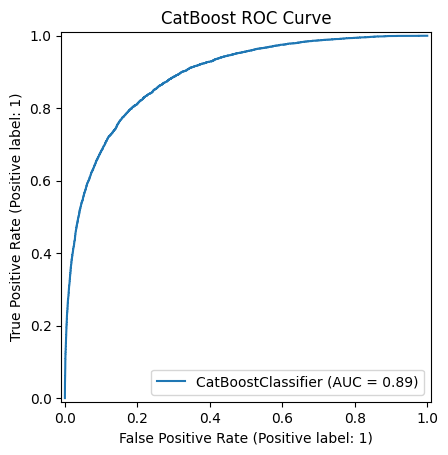

CatBoost ROC AUC Score: 0.7527788599831086


In [26]:
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, RocCurveDisplay
import matplotlib.pyplot as plt

catboost = CatBoostClassifier(verbose=0, random_state=0)
catboost.fit(X_train_res, y_train_res)

y_pred_catboost = catboost.predict(X_test)
print("\nCatBoost Model Evaluation: \n")
print("Confusion_matrix :")
print(confusion_matrix(y_test,y_pred_catboost))
print("Accuracy Score :")
print(accuracy_score(y_test,y_pred_catboost))
print("Classification Report :")
print(classification_report(y_test,y_pred_catboost))
RocCurveDisplay.from_estimator(catboost, X_test, y_test)
plt.title("CatBoost ROC Curve")
plt.show()
print("CatBoost ROC AUC Score:", metrics.roc_auc_score(y_test, y_pred_catboost, average=None))


XGBoost Model Evaluation: 

Confusion_matrix :
[[21422  1304]
 [ 2819  3547]]
Accuracy Score :
0.8582771896053898
Classification Report :
              precision    recall  f1-score   support

           0       0.88      0.94      0.91     22726
           1       0.73      0.56      0.63      6366

    accuracy                           0.86     29092
   macro avg       0.81      0.75      0.77     29092
weighted avg       0.85      0.86      0.85     29092



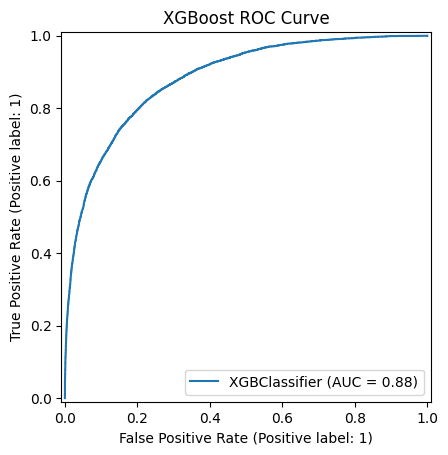

XGBoost ROC AUC Score: 0.7498997744690542


In [27]:
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, RocCurveDisplay
import matplotlib.pyplot as plt

xgb = XGBClassifier(random_state=0)
xgb.fit(X_train_res, y_train_res)

y_pred_xgb = xgb.predict(X_test)
print("\nXGBoost Model Evaluation: \n")
print("Confusion_matrix :")
print(confusion_matrix(y_test,y_pred_xgb))
print("Accuracy Score :")
print(accuracy_score(y_test,y_pred_xgb))
print("Classification Report :")
print(classification_report(y_test,y_pred_xgb))
RocCurveDisplay.from_estimator(xgb, X_test, y_test)
plt.title("XGBoost ROC Curve")
plt.show()
print("XGBoost ROC AUC Score:", metrics.roc_auc_score(y_test, y_pred_xgb, average=None))


GaussianNB Model Evaluation: 

Confusion_matrix :
[[18158  4568]
 [ 1999  4367]]
Accuracy Score :
0.7742678399560017
Classification Report :
              precision    recall  f1-score   support

           0       0.90      0.80      0.85     22726
           1       0.49      0.69      0.57      6366

    accuracy                           0.77     29092
   macro avg       0.69      0.74      0.71     29092
weighted avg       0.81      0.77      0.79     29092



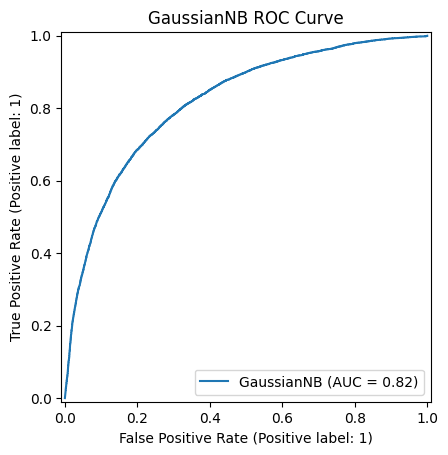

GaussianNB ROC AUC Score: 0.7424924026973911


In [28]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, RocCurveDisplay
import matplotlib.pyplot as plt

gnb = GaussianNB()
gnb.fit(X_train_res, y_train_res)

y_pred_gnb = gnb.predict(X_test)
print("\nGaussianNB Model Evaluation: \n")
print("Confusion_matrix :")
print(confusion_matrix(y_test,y_pred_gnb))
print("Accuracy Score :")
print(accuracy_score(y_test,y_pred_gnb))
print("Classification Report :")
print(classification_report(y_test,y_pred_gnb))
RocCurveDisplay.from_estimator(gnb, X_test, y_test)
plt.title("GaussianNB ROC Curve")
plt.show()
print("GaussianNB ROC AUC Score:", metrics.roc_auc_score(y_test, y_pred_gnb, average=None))

In [29]:
import pandas as pd

model_performance = {
    'Logistic Regression': {
        'Accuracy': accuracy_score(y_test, y_pred2),
        'Precision': metrics.precision_score(y_test, y_pred2),
        'Recall': metrics.recall_score(y_test, y_pred2),
        'F1-score': metrics.f1_score(y_test, y_pred2),
        'ROC AUC': metrics.roc_auc_score(y_test, y_pred2)
    },
    'KNeighborsClassifier': {
        'Accuracy': accuracy_score(y_test, y_pred4),
        'Precision': metrics.precision_score(y_test, y_pred4),
        'Recall': metrics.recall_score(y_test, y_pred4),
        'F1-score': metrics.f1_score(y_test, y_pred4),
        'ROC AUC': metrics.roc_auc_score(y_test, y_pred4)
    },
    'SVC': {
        'Accuracy': accuracy_score(y_test, y_pred5),
        'Precision': metrics.precision_score(y_test, y_pred5),
        'Recall': metrics.recall_score(y_test, y_pred5),
        'F1-score': metrics.f1_score(y_test, y_pred5),
        'ROC AUC': metrics.roc_auc_score(y_test, y_pred5)
    },
     'Random Forest': {
        'Accuracy': accuracy_score(y_test, y_pred_rf),
        'Precision': metrics.precision_score(y_test, y_pred_rf),
        'Recall': metrics.recall_score(y_test, y_pred_rf),
        'F1-score': metrics.f1_score(y_test, y_pred_rf),
        'ROC AUC': metrics.roc_auc_score(y_test, y_pred_rf)
    },
    'CatBoost': {
        'Accuracy': accuracy_score(y_test, y_pred_catboost),
        'Precision': metrics.precision_score(y_test, y_pred_catboost),
        'Recall': metrics.recall_score(y_test, y_pred_catboost),
        'F1-score': metrics.f1_score(y_test, y_pred_catboost),
        'ROC AUC': metrics.roc_auc_score(y_test, y_pred_catboost)
    },
    'XGBoost': {
        'Accuracy': accuracy_score(y_test, y_pred_xgb),
        'Precision': metrics.precision_score(y_test, y_pred_xgb),
        'Recall': metrics.recall_score(y_test, y_pred_xgb),
        'F1-score': metrics.f1_score(y_test, y_pred_xgb),
        'ROC AUC': metrics.roc_auc_score(y_test, y_pred_xgb)
    },
    'GaussianNB': {
        'Accuracy': accuracy_score(y_test, y_pred_gnb),
        'Precision': metrics.precision_score(y_test, y_pred_gnb),
        'Recall': metrics.recall_score(y_test, y_pred_gnb),
        'F1-score': metrics.f1_score(y_test, y_pred_gnb),
        'ROC AUC': metrics.roc_auc_score(y_test, y_pred_gnb)
    }
}

model_performance_df = pd.DataFrame(model_performance).T


display(model_performance_df)

,Accuracy,Precision,Recall,F1-score,ROC AUC
Logistic Regression,0.785439,0.506535,0.754948,0.606282,0.774464
KNeighborsClassifier,0.747834,0.449720,0.681433,0.541844,0.723934
SVC,0.800701,0.531086,0.762174,0.625984,0.786834
Random Forest,0.844665,0.652872,0.619541,0.635770,0.763634
CatBoost,0.862952,0.752494,0.556865,0.640065,0.752779
XGBoost,0.858277,0.731189,0.557179,0.632433,0.749900
GaussianNB,0.774268,0.488752,0.685988,0.570812,0.742492


In [30]:
param_grid = {
    'iterations': [50, 100, 150],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5]
}

In [31]:
from sklearn.model_selection import GridSearchCV

catboost = CatBoostClassifier(verbose=0, random_state=0)

grid_search = GridSearchCV(estimator=catboost, param_grid=param_grid, cv=5, scoring='roc_auc')

In [32]:
grid_search.fit(X_train_res, y_train_res)

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x000001D0DB20ABD0>,
             param_grid={'depth': [4, 6, 8], 'iterations': [50, 100, 150],
                         'l2_leaf_reg': [1, 3, 5],
                         'learning_rate': [0.01, 0.05, 0.1]},
             scoring='roc_auc')

In [33]:
print("Best parameters found: ", grid_search.best_params_)
print("Best ROC AUC score: ", grid_search.best_score_)

Best parameters found:  {'depth': 8, 'iterations': 150, 'l2_leaf_reg': 1, 'learning_rate': 0.1}
Best ROC AUC score:  0.9634413580120974



Tuned CatBoost Model Evaluation: 

Confusion_matrix :
[[21489  1237]
 [ 2972  3394]]
Accuracy Score :
0.8553210504606077
Classification Report :
              precision    recall  f1-score   support

           0       0.88      0.95      0.91     22726
           1       0.73      0.53      0.62      6366

    accuracy                           0.86     29092
   macro avg       0.81      0.74      0.76     29092
weighted avg       0.85      0.86      0.85     29092



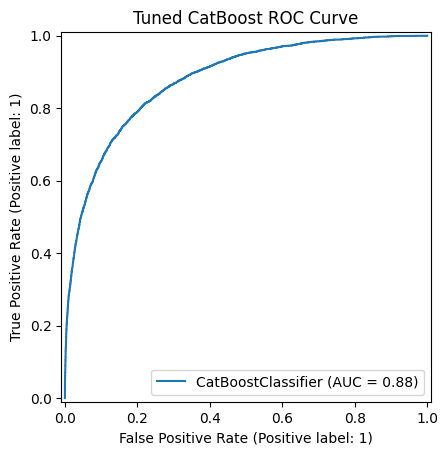

Tuned CatBoost ROC AUC Score: 0.7393568918904385


In [34]:
# Train the CatBoost model with the best parameters
best_catboost_model = CatBoostClassifier(verbose=0, random_state=0, **grid_search.best_params_)
best_catboost_model.fit(X_train_res, y_train_res)

# Evaluate the tuned model on the test set
y_pred_tuned_catboost = best_catboost_model.predict(X_test)

print("\nTuned CatBoost Model Evaluation: \n")
print("Confusion_matrix :")
print(confusion_matrix(y_test,y_pred_tuned_catboost))
print("Accuracy Score :")
print(accuracy_score(y_test,y_pred_tuned_catboost))
print("Classification Report :")
print(classification_report(y_test,y_pred_tuned_catboost))
RocCurveDisplay.from_estimator(best_catboost_model, X_test, y_test)
plt.title("Tuned CatBoost ROC Curve")
plt.show()
print("Tuned CatBoost ROC AUC Score:", metrics.roc_auc_score(y_test, y_pred_tuned_catboost, average=None))

In [35]:
import joblib

# Save the best CatBoost model
joblib.dump(best_catboost_model, 'best_catboost_model.pkl')

print("Best CatBoost model saved as 'best_catboost_model.pkl'")

Best CatBoost model saved as 'best_catboost_model.pkl'
